In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax import jit, vmap, grad, value_and_grad

from configs import Lorenz63Config, LorenzSystem
from models import lorenz63_step 
from metrics import rmse
from plotting import plot_rmse_stackplot, plot_cross_val

from cost_functions import (
    bayes_cost_function,
    dci_cost_function,
    dci_wme_cost_function,
)

import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
jax.config.update("jax_enable_x64", True)

/var/folders/14/4_5vrl2912bc84l063zdm5l80000gq/T/ipykernel_80110/1596409752.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/rylanspence/Desktop/Git/DC/Thesis/Variational-Data-Consistent-Assimilation/plotting.py:274: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma_{\mathrm{obs}}$", fontsize=44, fontweight="bold")


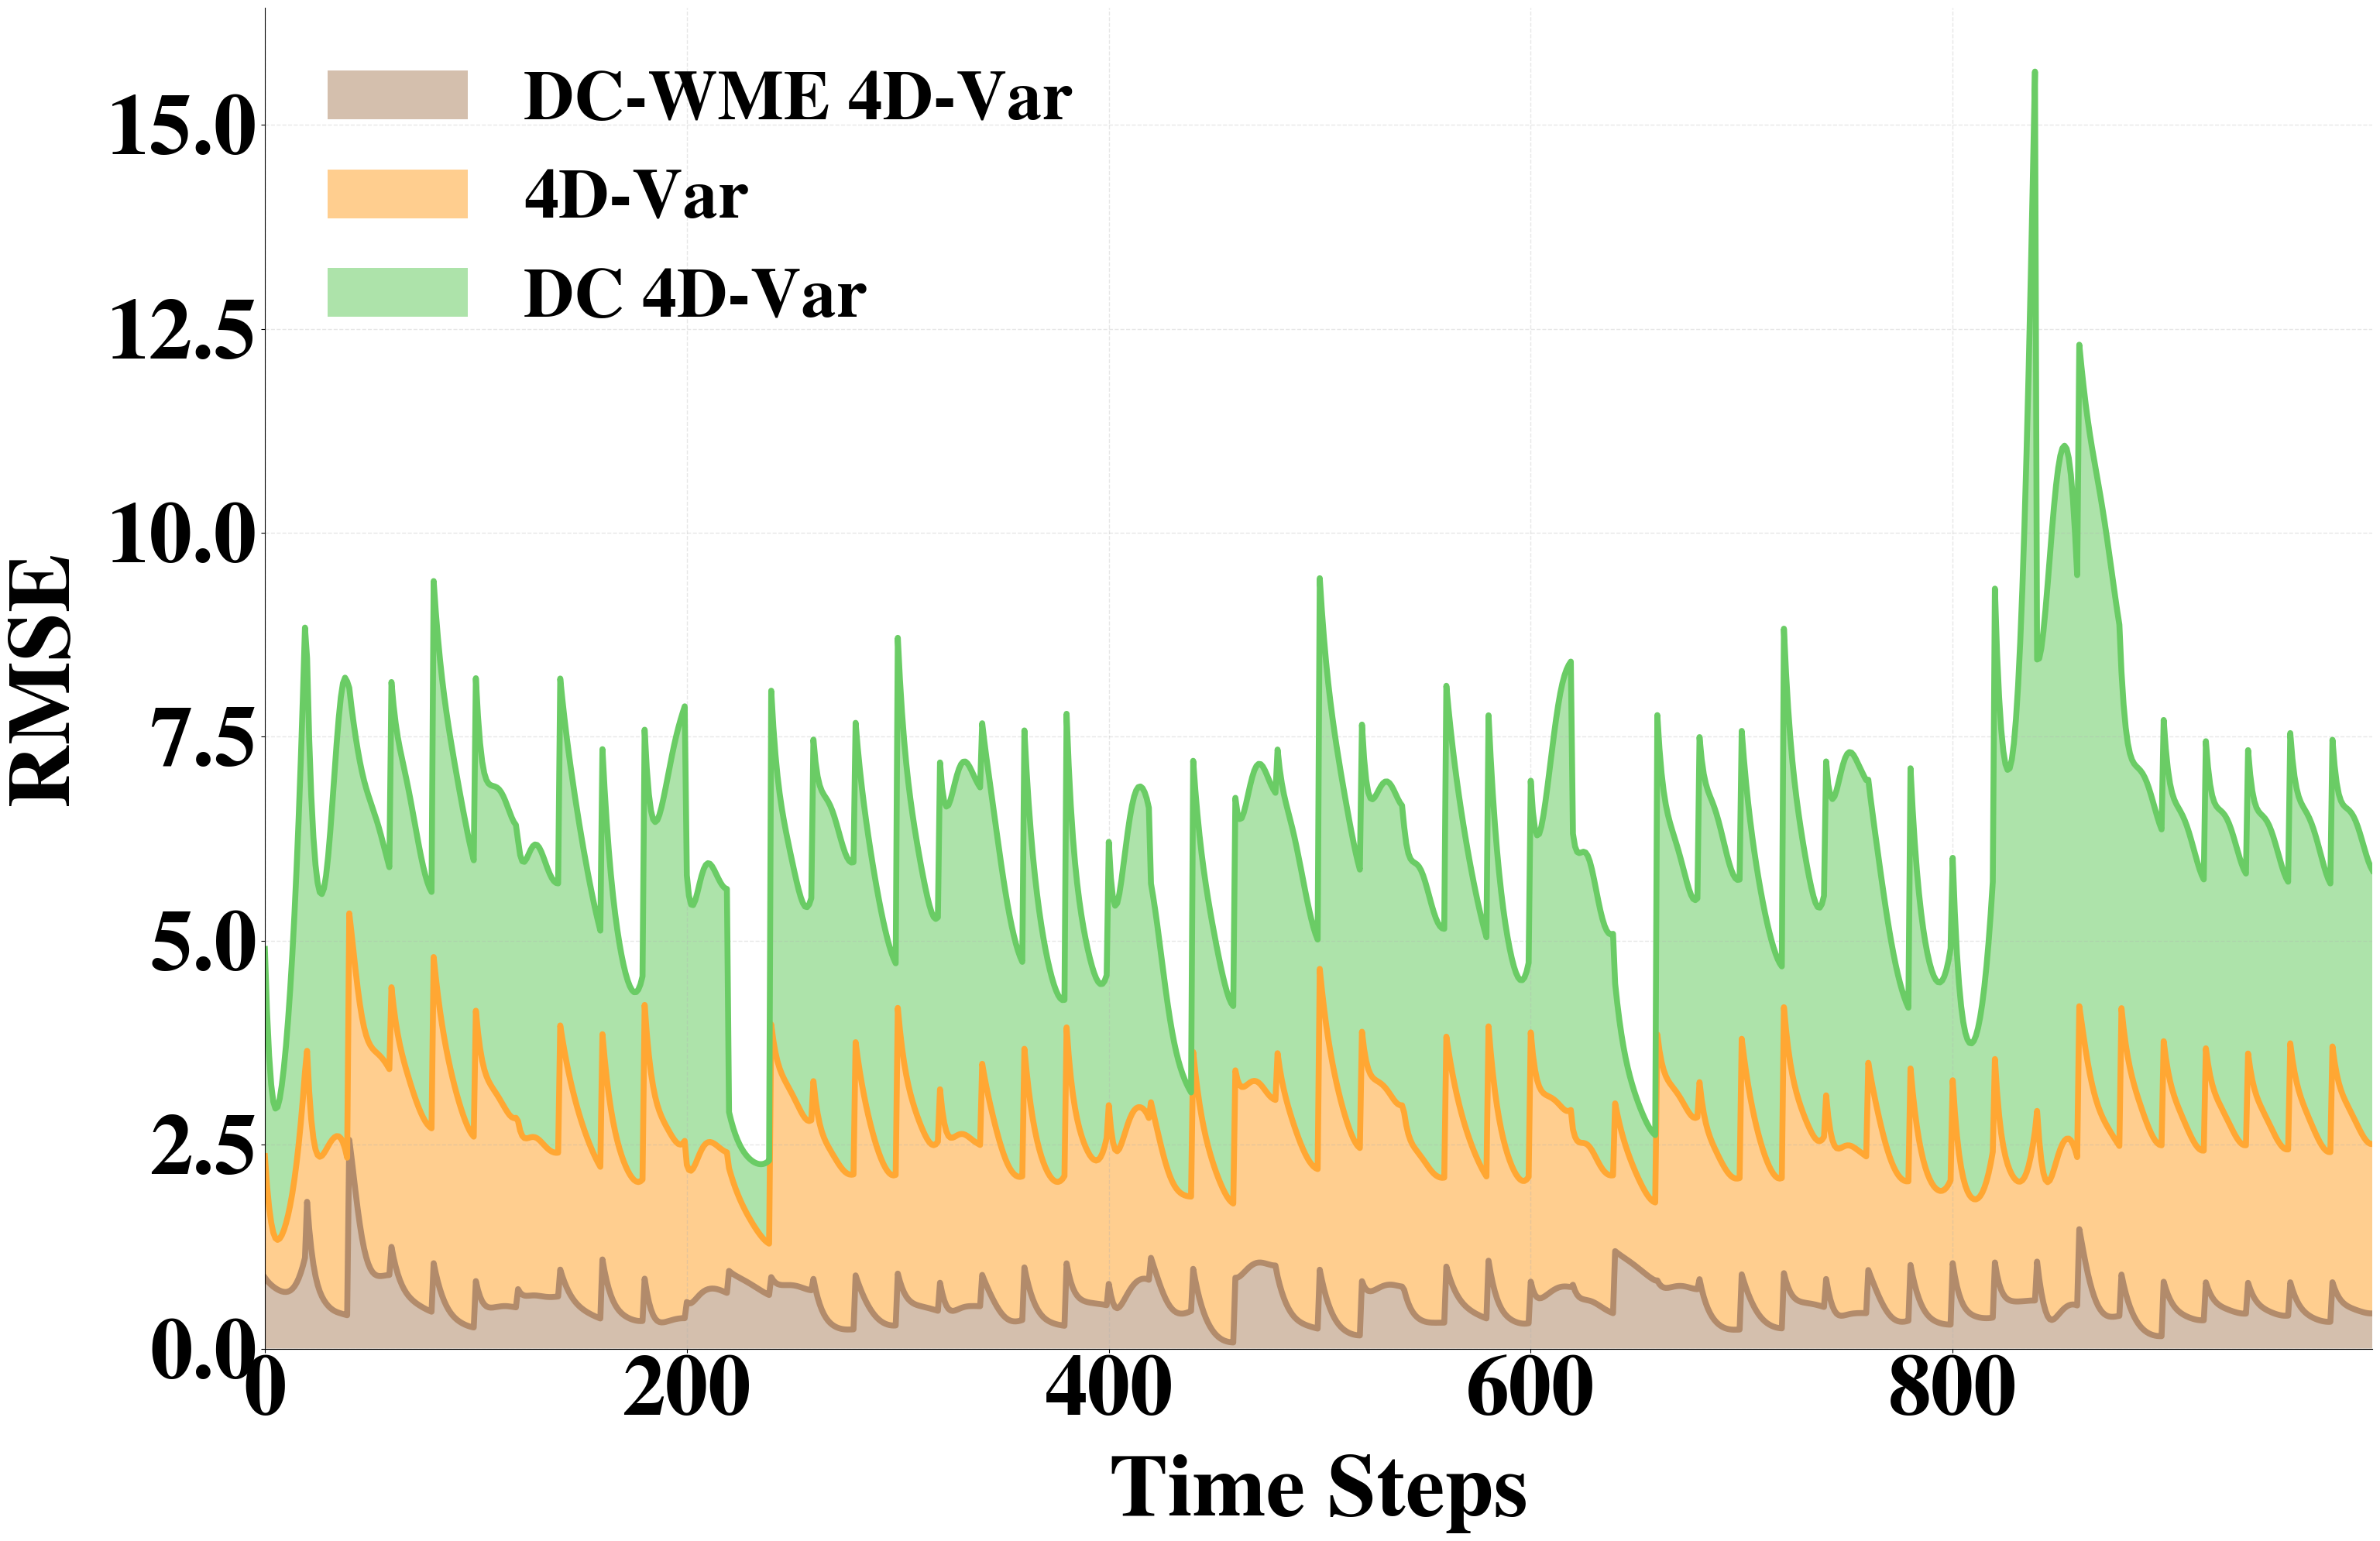

In [18]:
# Main execution function
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

# Create system and run experiment
config_avg = Lorenz63Config.default_config(
    total_steps=1000, window_size=20, obs_frequency=4, 
    obs_std=2.0, inflation_factor=12
)
system_avg = LorenzSystem(config_avg, lorenz63_step, cost_functions)
results_avg = system_avg.run_experiment()

# Create results dataframe
df_avg = pd.DataFrame.from_dict(results_avg['results'], orient='index')

# Calculate RMSE scores for all models
rmse_scores = pd.DataFrame({
    model: rmse(results_avg['analysis'][model], results_avg['trajectory'])
    for model in cost_functions.keys()
})

plot_params = {
    "lines.linewidth": 8,
    "lines.markersize": 25,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 65,
    "legend.frameon": False,
    "legend.title_fontsize": "50",
    "xtick.labelsize": 80,
    "ytick.labelsize": 80,
    "axes.labelsize": 82,
    "axes.labelpad": 20,
    "axes.titlesize": 50,
    "figure.figsize": (30, 20),
}

fig, ax = plot_rmse_stackplot(rmse_scores, plot_params=plot_params, save=False)

_____

,0.5,1.0,1.5,2.0,2.5,3.0
Observation_Density,,,,,,
10,0.742866,0.801948,0.913592,1.054278,1.213547,1.392994
5,0.579395,0.792905,1.157716,1.596398,2.068370,2.565239
4,0.521784,0.513663,0.553460,0.623412,0.727702,0.852467


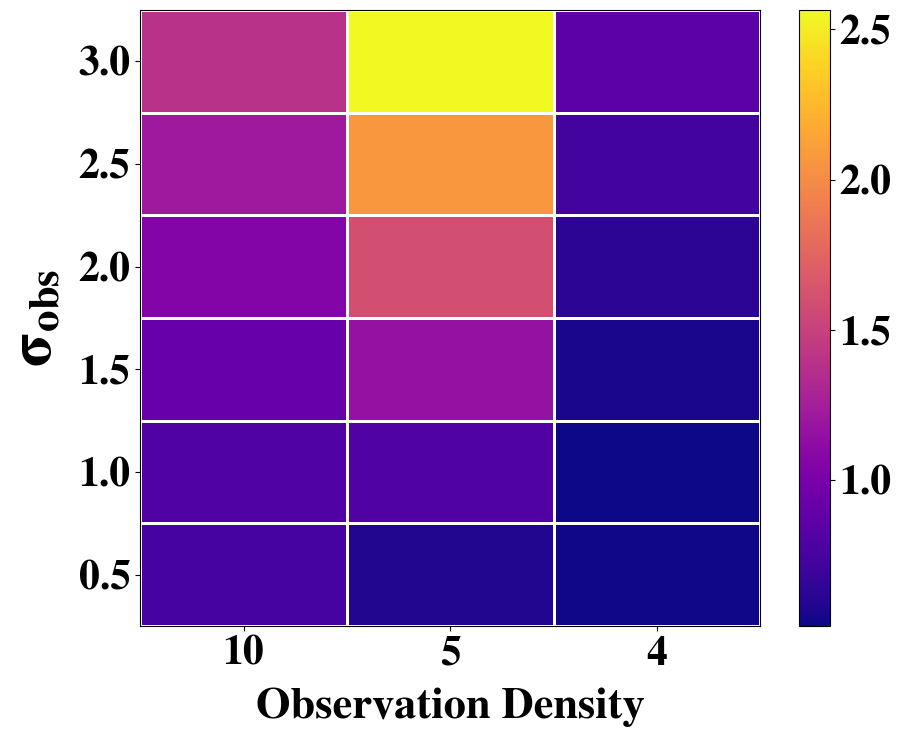

In [20]:
cost_functions = {
    'DCI_WME': dci_wme_cost_function
}

noise_levels = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
obs_freqs = [4, 5, 10]
noise_level_dfs = []

rmse_noise_dfs = []
misfit_noise_dfs = []
rel_error_noise_dfs = []
for obs_freq in obs_freqs:
    noise_level_dfs = []
    for noise in noise_levels:
        config = Lorenz63Config.default_config(total_steps=500, window_size=20, obs_frequency=obs_freq, obs_std=noise, inflation_factor=4*(noise**2))
        system = LorenzSystem(config, lorenz63_step, cost_functions)
        results = system.run_experiment()
        df = pd.DataFrame.from_dict(results['results'], orient='index')
        noise_level_dfs.append(df)


    rmse_noise = pd.concat(map(lambda df: df.rmse, noise_level_dfs), axis=1)
    misfit_noise = pd.concat(map(lambda df: df.misfit, noise_level_dfs), axis=1)
    rel_error_noise = pd.concat(map(lambda df: df.relative_error, noise_level_dfs), axis=1)
    misfit_noise.columns = noise_levels
    rmse_noise.columns = noise_levels
    rel_error_noise.columns = noise_levels

    rmse_noise_dfs.append(rmse_noise)
    misfit_noise_dfs.append(misfit_noise)
    rel_error_noise_dfs.append(rel_error_noise)
    
obs2_df = rmse_noise_dfs[0].assign(Observation_Density=4)
obs4_df = rmse_noise_dfs[1].assign(Observation_Density=5)
obs5_df = rmse_noise_dfs[2].assign(Observation_Density=10)
obs_df = pd.concat([obs2_df, obs4_df, obs5_df])



dci_wme_obs = obs_df.loc['DCI_WME']
dci_wme_obs = dci_wme_obs.iloc[::-1]
dci_wme_obs = dci_wme_obs.set_index('Observation_Density')
display(dci_wme_obs)

plot_params = {
    "lines.linewidth": 10,
    "lines.markersize": 20,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 30,
    "legend.frameon": False,
    "legend.title_fontsize": 20,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "axes.labelsize": 32,
    "axes.labelpad": 10,
    "axes.titlesize": 20,
    "figure.figsize": (10, 8),
    'font.weight': 'bold',
}

plot_cross_val(dci_wme_obs.T, plot_params, file_name="dci_wme_noisevdensity")

In [19]:
cost_functions = {'DCI_WME': dci_wme_cost_function}
noise_levels = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
obs_freqs = [4, 5, 10]

rmse_noise_dfs, misfit_noise_dfs, rel_error_noise_dfs = [], [], []

for obs_freq in obs_freqs:
    # Run experiments for all noise levels
    dfs = []
    for noise in noise_levels:
        config = Lorenz63Config.default_config(
            total_steps=500, window_size=20, obs_frequency=obs_freq, 
            obs_std=noise, inflation_factor=4*(noise**2)
        )
        system = LorenzSystem(config, lorenz63_step, cost_functions)
        results = system.run_experiment()
        dfs.append(pd.DataFrame.from_dict(results['results'], orient='index'))
    
    # Concatenate and store results
    metrics = ['rmse', 'misfit', 'relative_error']
    for metric, storage in zip(metrics, [rmse_noise_dfs, misfit_noise_dfs, rel_error_noise_dfs]):
        combined = pd.concat([getattr(df, metric) for df in dfs], axis=1)
        combined.columns = noise_levels
        storage.append(combined)

# Create final observation density dataframe
obs_df = pd.concat([
    df.assign(Observation_Density=freq) 
    for df, freq in zip(rmse_noise_dfs, obs_freqs)
])


dci_wme_obs = obs_df.loc['DCI_WME']
dci_wme_obs = dci_wme_obs.iloc[::-1]
dci_wme_obs = dci_wme_obs.set_index('Observation_Density')
dci_wme_obs

,0.5,1.0,1.5,2.0,2.5,3.0
Observation_Density,,,,,,
10,0.742866,0.801948,0.913592,1.054278,1.213547,1.392994
5,0.579395,0.792905,1.157716,1.596398,2.068370,2.565239
4,0.521784,0.513663,0.553460,0.623412,0.727702,0.852467


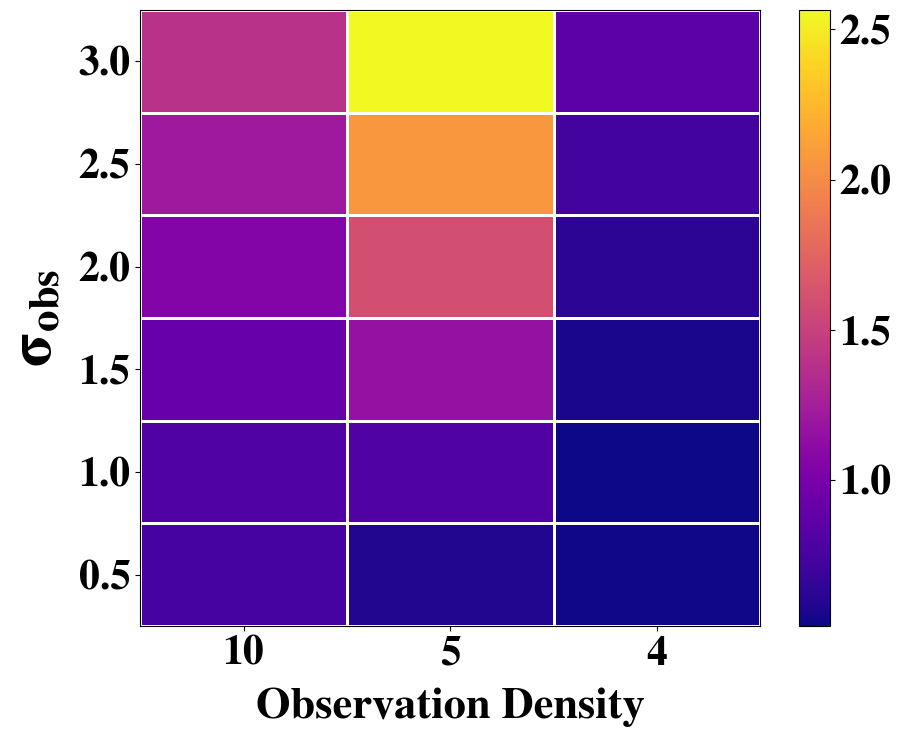

In [8]:
plot_params = {
    "lines.linewidth": 10,
    "lines.markersize": 20,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 30,
    "legend.frameon": False,
    "legend.title_fontsize": 20,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "axes.labelsize": 32,
    "axes.labelpad": 10,
    "axes.titlesize": 20,
    "figure.figsize": (10, 8),
    'font.weight': 'bold',
}

plot_cross_val(dci_wme_obs.T, plot_params, file_name="dci_wme_noisevdensity")

____

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eigvalsh
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Lorenz 63 parameters
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

def lorenz63(t, state):
    """Lorenz 63 system"""
    x, y, z = state
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

def lorenz63_jacobian(state):
    """Jacobian of Lorenz 63"""
    x, y, z = state
    return np.array([
        [-sigma, sigma, 0],
        [rho - z, -1, -x],
        [y, x, -beta]
    ])

def propagate_jacobian(z0, t_final, dt=0.01):
    """Tangent linear propagation of Jacobian"""
    n, J, z, t = len(z0), np.eye(len(z0)), np.array(z0), 0.0
    
    while t < t_final:
        A = lorenz63_jacobian(z)
        J += dt * A @ J
        z += dt * np.array(lorenz63(0, z))
        t += dt
    return J

# Parameters and setup
gamma, sigma_obs_sq, N_obs, t_final = 0.1, 2.0, 5, 10.0
H = np.array([[1, 0, 0], [0, 1, 0]])  # Observation operator

# Generate initial conditions and compute bounds
np.random.seed(0)
initial_conditions = np.random.uniform(-5, 5, size=(50, 3))

def compute_bound(z0):
    """Compute bound for given initial condition"""
    Q = H @ propagate_jacobian(z0, t_final)
    lambda_min = eigvalsh(Q @ Q.T).min()
    return (gamma * sigma_obs_sq**2) / (N_obs * lambda_min)

bounds = [compute_bound(z0) for z0 in initial_conditions]

average_bound = np.mean(bounds)
print(f"Average estimated lower bound on $\\sigma_b^2$ over 50 trajectories: {average_bound:.3f}")


Average estimated lower bound on $\sigma_b^2$ over 50 trajectories: 16.830


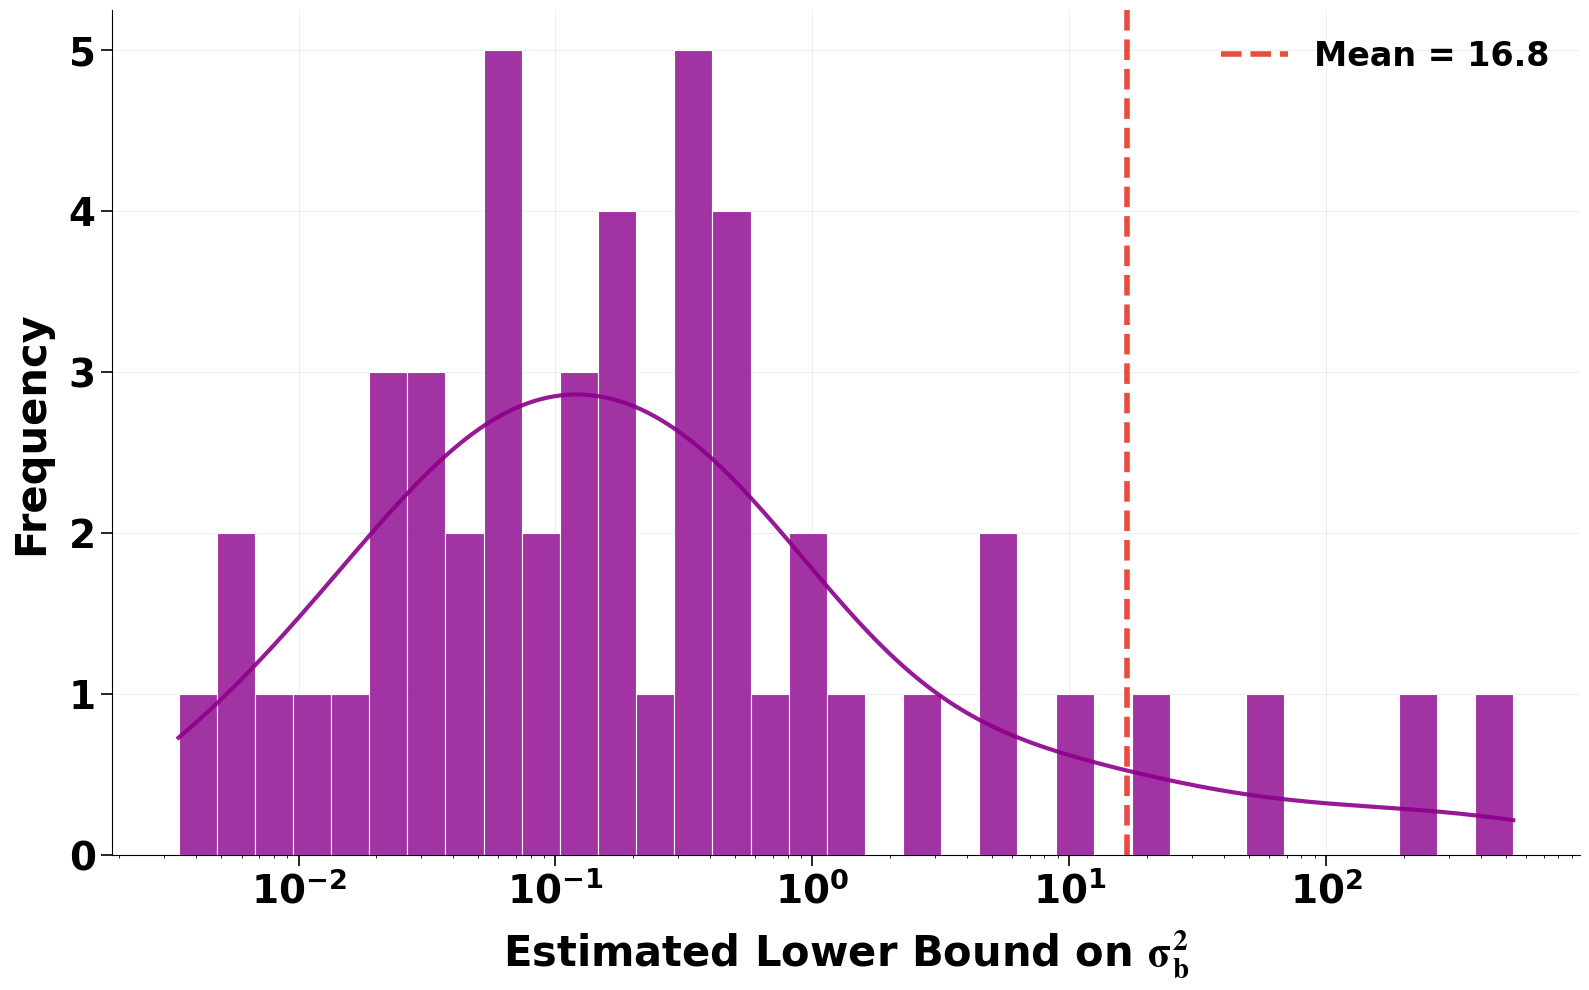

In [22]:
# Enhanced histogram with improved visual appeal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume `data` is your 1D array of estimates
data = np.array(bounds)  # Replace with actual data

plot_params = {
    "lines.linewidth": 4,
    'lines.markeredgecolor': 'black',
    'legend.fontsize': 24,
    'legend.frameon': False,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "axes.labelsize": 30,
    "axes.labelpad": 12,
    "figure.figsize": (16, 10),
    "axes.titleweight": 'bold',
    "axes.labelweight": 'bold',
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
}

with plt.rc_context(plot_params):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Set background color for better contrast
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Create histogram with improved styling
    sns.histplot(
        data,
        kde=True,
        log_scale=(True, False),
        color="darkmagenta",
        edgecolor="white",  # White edges for cleaner look
        linewidth=0.8,
        alpha=0.8,  # Slight transparency
        bins=35,  # More bins for smoother distribution
        line_kws={'linewidth': 3, 'color': 'darkmagenta', 'alpha': 0.9}
    )

    # Add mean line with improved styling
    mean_val = data.mean()
    ax.axvline(
        mean_val,
        color='#e74c3c',
        linestyle='--',
        linewidth=4,
        alpha=1.0,
        label=f"Mean = {mean_val:.1f}"
    )


    # Improve axis labels and title
    ax.set_xlabel("Estimated Lower Bound on $\\sigma_b^2$", fontweight='bold')
    ax.set_ylabel("Frequency", fontweight='bold')

    # Enhance legend
    legend = ax.legend(
        loc="upper right",
        frameon=False,
        fancybox=True,
        shadow=True,
        framealpha=0.9,
        facecolor='white',
        edgecolor='white'
    )

    # Add subtle grid for better readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Improve tick formatting
    ax.tick_params(axis='both', which='major', length=8, width=1.2)


    plt.tight_layout()
    plt.savefig("sigma_b_bound_distribution.png", dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()